Мы продолжаем осваивать инструменты программирования нейронных сетей. Текущей задачей является изучения примера реального исследования для производственных процессов компании Северсталь.
Ссылка на каггл с этим соревнованием - https://www.kaggle.com/c/severstal-steel-defect-detection

Этот конкурс представляет собой двойной конкурс: классифицируйте тип дефекта стали, а также сегментируйте части изображения, содержащие дефект.

Нашей задачей является изучения методов использованных в оптимальной модели и попытка ее улучшения через подбор параметров.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import keras
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Dropout

In [2]:
data = pd.read_csv('train.csv')

In [3]:
data

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
...,...,...,...
7090,ffcf72ecf.jpg,3,121911 34 122167 101 122422 169 122678 203 122...
7091,fff02e9c5.jpg,3,207523 3 207777 9 208030 15 208283 22 208537 2...
7092,fffe98443.jpg,3,105929 5 106177 14 106424 24 106672 33 106923 ...
7093,ffff4eaa8.jpg,3,16899 7 17155 20 17411 34 17667 47 17923 60 18...


In [4]:
data.shape

(7095, 3)

# Разведочный анализ данных

ClassId
3    5150
1     897
4     801
2     247
Name: count, dtype: int64

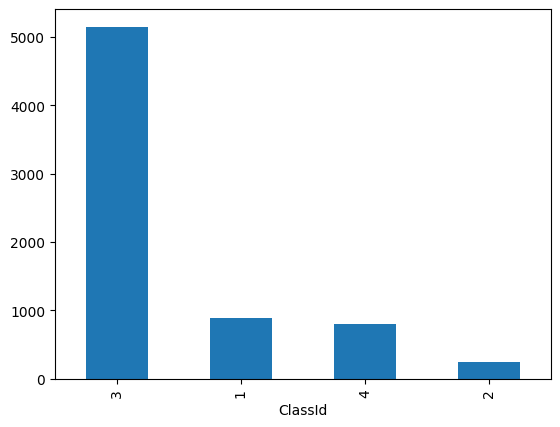

In [5]:
data["ClassId"].value_counts().plot(kind = 'bar')
data["ClassId"].value_counts()

In [6]:
data["ClassId"]

0       1
1       3
2       1
3       4
4       3
       ..
7090    3
7091    3
7092    3
7093    3
7094    3
Name: ClassId, Length: 7095, dtype: int64

Больше всего меток третьего класса. К сожалению у нас нет описания датасета и не понятен контекст меток. Возможно 3 класс эта метка отвечает за изделия без дефекта.

Перекос данных, поэтому выполним аугментацию.

In [5]:
import cv2

In [9]:
!unzip "train_images.zip" -d "train_images"

Archive:  train_images.zip
  inflating: train_images/f00185797.jpg  
  inflating: train_images/f0074b888.jpg  
  inflating: train_images/f0075e43c.jpg  
  inflating: train_images/f024c4789.jpg  
  inflating: train_images/f03379160.jpg  
  inflating: train_images/f0344b3ad.jpg  
  inflating: train_images/f035b1e71.jpg  
  inflating: train_images/f0437a9c3.jpg  
  inflating: train_images/f046dc5fa.jpg  
  inflating: train_images/f061c7c53.jpg  
  inflating: train_images/f0625054e.jpg  
  inflating: train_images/f07399cf6.jpg  
  inflating: train_images/f07969848.jpg  
  inflating: train_images/f0859ea87.jpg  
  inflating: train_images/f08716423.jpg  
  inflating: train_images/f10768627.jpg  
  inflating: train_images/f10e66f64.jpg  
  inflating: train_images/f10f625fd.jpg  
  inflating: train_images/f1119e073.jpg  
  inflating: train_images/f11471db2.jpg  
  inflating: train_images/f114d1a28.jpg  
  inflating: train_images/f11d59e33.jpg  
  inflating: train_images/f12206185.jpg  
  infla

In [6]:
l1=[]
l2=[]
for img,ClassId,EncodedPixels in tqdm(data.values):
    try:
      image=cv2.imread("train_images/{}".format(img),cv2.IMREAD_COLOR)
      image = cv2.resize(image,(800,128))
      l1.append(image)
      l2.append(ClassId)
    except:
      continue





100%|██████████| 7095/7095 [00:04<00:00, 1453.75it/s]


array([[[  1,   1,   1],
        [  2,   2,   2],
        [  2,   2,   2],
        ...,
        [ 67,  67,  67],
        [ 68,  68,  68],
        [ 68,  68,  68]],

       [[  2,   2,   2],
        [  2,   2,   2],
        [  2,   2,   2],
        ...,
        [ 69,  69,  69],
        [ 66,  66,  66],
        [ 71,  71,  71]],

       [[  2,   2,   2],
        [  2,   2,   2],
        [  2,   2,   2],
        ...,
        [ 64,  64,  64],
        [ 66,  66,  66],
        [ 68,  68,  68]],

       ...,

       [[  1,   1,   1],
        [  1,   1,   1],
        [  1,   1,   1],
        ...,
        [106, 106, 106],
        [104, 104, 104],
        [108, 108, 108]],

       [[  1,   1,   1],
        [  1,   1,   1],
        [  1,   1,   1],
        ...,
        [106, 106, 106],
        [102, 102, 102],
        [102, 102, 102]],

       [[  1,   1,   1],
        [  2,   2,   2],
        [  2,   2,   2],
        ...,
        [107, 107, 107],
        [104, 104, 104],
        [104, 104, 104]]], dtype=uint8)
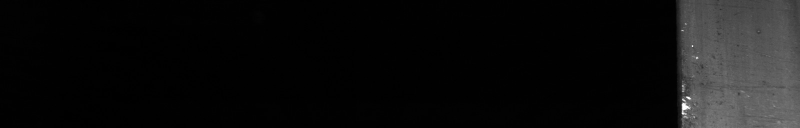

In [7]:
l1[0]

In [123]:
len(l1)

351

Проверка изображений случайной стали, чтобы проверить, дефектна ли она или нет.

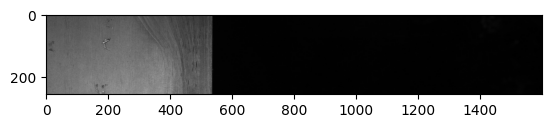

In [124]:
i = 1
plt.imshow(l1[i])

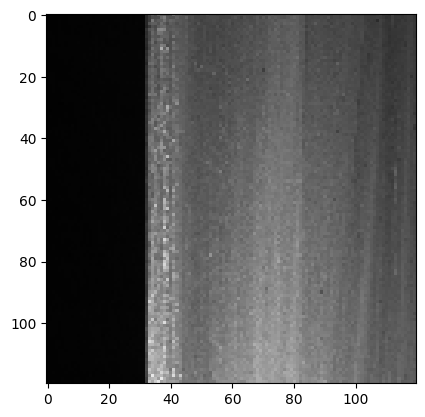

In [14]:
i = 16
plt.imshow(l1[i])

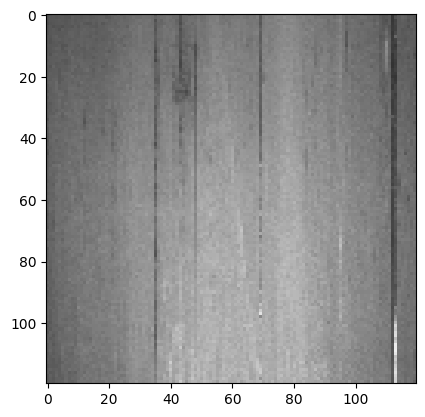

In [ ]:
i = 90
plt.imshow(l1[i])

Выполним one-hot кодировку

In [8]:
encoder = LabelEncoder()

X= np.array(l1)
X = X/255

y = encoder.fit_transform(l2)
y = np.array(y)


In [9]:
X.shape

(351, 128, 800, 3)

In [10]:
y.shape

(351,)

# Борьба с дибалансом

для борьбы с дисбалансом выполним случайное сэмплирование

In [111]:
from imblearn.over_sampling import RandomOverSampler
reshaped_X = X.reshape(X.shape[0],-1)
oversample = RandomOverSampler(sampling_strategy='not majority')
X, y  = oversample.fit_resample(reshaped_X , y)
X = X.reshape(-1,120,120,3)

In [128]:
X.shape

(351, 256, 1600, 3)

In [11]:

y = to_categorical(y)

In [12]:
y

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

разделим на тренировку и валидацию

In [13]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,shuffle=True)

In [14]:
print("x_train размер:",X_train.shape)
print("x_test размер:",X_test.shape)
print("y_train размер:",y_train.shape)
print("y_test размер:",y_test.shape)

x_train размер: (280, 128, 800, 3)
x_test размер: (71, 128, 800, 3)
y_train размер: (280, 4)
y_test размер: (71, 4)


# Построение нейронной сети  в 3 слоя и график обучения

In [15]:
model=Sequential()
model.add(Conv2D(32,(3,3),input_shape=(128,800,3),activation="relu"))
model.add(Flatten())
model.add(Dense(4,activation="softmax"))

In [16]:
model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
             metrics=["accuracy"])

In [17]:
history = model.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test),batch_size=128,
                    verbose=1)

Epoch 1/10
3/3 [==============================] - 7s 864ms/step - loss: 13.3646 - accuracy: 0.4964 - val_loss: 35.9372 - val_accuracy: 0.7042
Epoch 2/10
3/3 [==============================] - 1s 197ms/step - loss: 24.5256 - accuracy: 0.7107 - val_loss: 17.6960 - val_accuracy: 0.1549
Epoch 3/10
3/3 [==============================] - 1s 181ms/step - loss: 9.8970 - accuracy: 0.3214 - val_loss: 6.4261 - val_accuracy: 0.7324
Epoch 4/10
3/3 [==============================] - 1s 207ms/step - loss: 5.5619 - accuracy: 0.7179 - val_loss: 6.9342 - val_accuracy: 0.7042
Epoch 5/10
3/3 [==============================] - 1s 208ms/step - loss: 4.4231 - accuracy: 0.6643 - val_loss: 2.0164 - val_accuracy: 0.6056
Epoch 6/10
3/3 [==============================] - 1s 245ms/step - loss: 1.3923 - accuracy: 0.6286 - val_loss: 1.7016 - val_accuracy: 0.6197
Epoch 7/10
3/3 [==============================] - 1s 205ms/step - loss: 0.9393 - accuracy: 0.7071 - val_loss: 1.2176 - val_accuracy: 0.6761
Epoch 8/10
3/3 [

<Axes: title={'center': 'Loss curve'}>

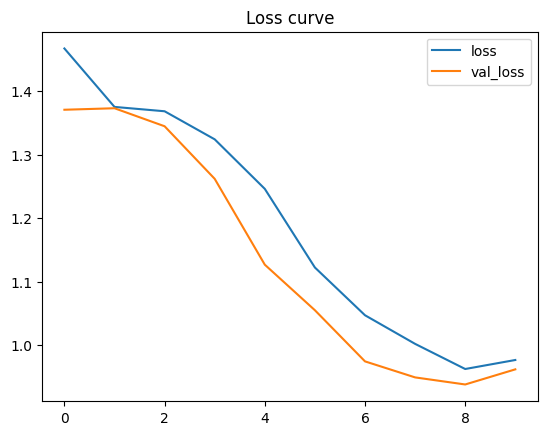

In [64]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title = 'Loss curve')

<Axes: title={'center': 'Accuracy curve'}>

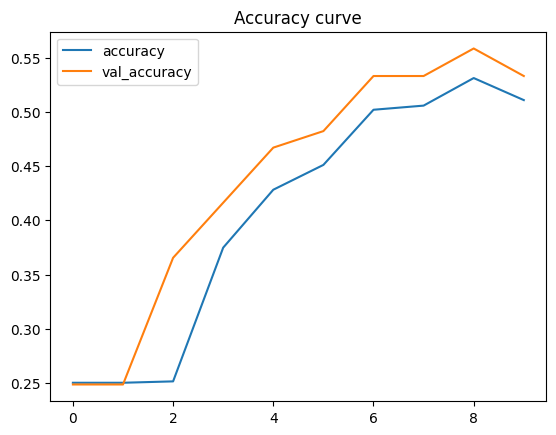

In [65]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title = 'Accuracy curve')

### Первые итоги.

Мы провели первые тесты эффективности нейронной сети на двух датасетах. Первый это базовый датасет из 351 примера, второй это расширенные аугментацией данные методом случайного семплирования RandomOverSampler(sampling_strategy='not majority') до 984 примеров.

Итог весьма противоречивый. Для базового датасета получен резульат
Epoch 10/10
3/3 [==============================] - 0s 37ms/step - loss: 0.5197 - accuracy: 0.8107 - val_loss: 0.9302 - val_accuracy: 0.7183

А для расширенного

Epoch 10/10
7/7 [==============================] - 0s 40ms/step - loss: 0.9763 - accuracy: 0.5108 - val_loss: 0.9616 - val_accuracy: 0.5330

То есть мы видим ухудшение эффективности обучения нейросети.
Зная вероятносный характер процесса обучения при заданных параметрах мы провели несколько запусков обучения нейросети и средний дезульта последней эпохи составил

Epoch 10/10
7/7 [==============================] - 0s 40ms/step - loss: 0.5208 - accuracy: 0.7776 - val_loss: 0.6771 - val_accuracy: 0.6853

То есть все равно хуже исходного датасета. Определнно выбранным метод аугментации не эффективен.


# Построение нейронной сети  в 5 слоев

In [21]:
model=Sequential()
model.add(Conv2D(32,(3,3),input_shape=(128,800,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dense(4,activation="softmax"))


In [22]:
model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
             metrics=["accuracy"])

In [24]:
history = model.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test),batch_size=128,
                    verbose=1)

Epoch 1/10
3/3 [==============================] - 1s 331ms/step - loss: 0.6463 - accuracy: 0.8214 - val_loss: 0.9659 - val_accuracy: 0.6197
Epoch 2/10
3/3 [==============================] - 1s 191ms/step - loss: 0.6056 - accuracy: 0.8107 - val_loss: 0.9493 - val_accuracy: 0.6761
Epoch 3/10
3/3 [==============================] - 1s 211ms/step - loss: 0.5784 - accuracy: 0.7929 - val_loss: 0.9793 - val_accuracy: 0.6901
Epoch 4/10
3/3 [==============================] - 1s 209ms/step - loss: 0.5439 - accuracy: 0.7929 - val_loss: 0.9597 - val_accuracy: 0.6620
Epoch 5/10
3/3 [==============================] - 1s 184ms/step - loss: 0.4720 - accuracy: 0.8214 - val_loss: 0.9539 - val_accuracy: 0.6479
Epoch 6/10
3/3 [==============================] - 1s 182ms/step - loss: 0.4166 - accuracy: 0.8571 - val_loss: 1.0158 - val_accuracy: 0.6338
Epoch 7/10
3/3 [==============================] - 1s 184ms/step - loss: 0.3864 - accuracy: 0.8750 - val_loss: 1.0917 - val_accuracy: 0.6479
Epoch 8/10
3/3 [====

<Axes: title={'center': 'Loss curve'}>

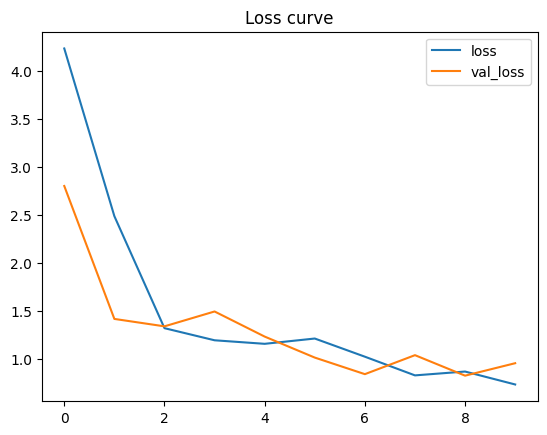

In [32]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title = 'Loss curve')

<Axes: title={'center': 'Accuracy curve'}>

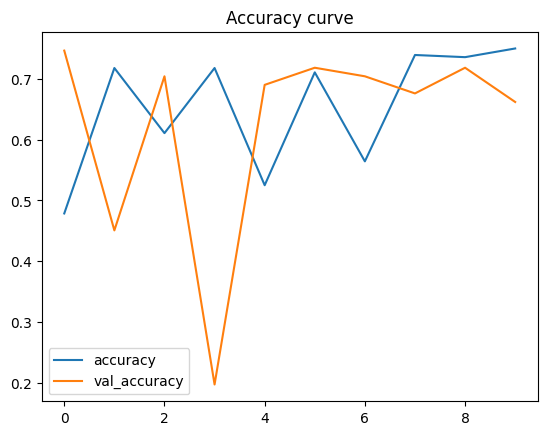

In [33]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title = 'Accuracy curve')

### Второй тест

Мы повторили тест с разными датасетами для второй нейросети с 5 слоями.
В данном случае результаты так же имеют вероятносный  разброс результатов ,но уже не такой большой.
Для оригинального датасета

Epoch 8/10
7/7 [==============================] - 0s 39ms/step - loss: 0.1665 - accuracy: 0.9568 - val_loss: 0.3203 - val_accuracy: 0.9137
Epoch 9/10
7/7 [==============================] - 0s 42ms/step - loss: 0.1593 - accuracy: 0.9568 - val_loss: 0.3132 - val_accuracy: 0.9036
Epoch 10/10
7/7 [==============================] - 0s 37ms/step - loss: 0.1615 - accuracy: 0.9504 - val_loss: 0.3036 - val_accuracy: 0.9239

Для расширенного

Epoch 8/10
7/7 [==============================] - 0s 43ms/step - loss: 0.1392 - accuracy: 0.9517 - val_loss: 0.2323 - val_accuracy: 0.9340
Epoch 9/10
7/7 [==============================] - 0s 37ms/step - loss: 0.1411 - accuracy: 0.9352 - val_loss: 0.2586 - val_accuracy: 0.9188
Epoch 10/10
7/7 [==============================] - 0s 36ms/step - loss: 0.1405 - accuracy: 0.9454 - val_loss: 0.2199 - val_accuracy: 0.9289

Данная арзитектура более устойчива к искажениям датасета, но в то же время не показывает и какого либо преимущества.

# Построение нейронной сети в 13 слоев и обучение

In [25]:
model=Sequential()
model.add(Conv2D(32,(3,3),input_shape=(128,800,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Conv2D(64,(3,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Conv2D(64,(3,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(256,activation="relu"))
model.add(Dense(4,activation="softmax"))

In [ ]:
# early_stopping = tf.keras.callbacks.EarlyStopping(patience=5,min_delta=0.001,restore_best_weights=True)

Сборка и обучение модели

In [26]:
model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
             metrics=["accuracy"])

In [27]:
history = model.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test),batch_size=128,
                    verbose=1)

Epoch 1/10
3/3 [==============================] - 10s 1s/step - loss: 1.2751 - accuracy: 0.5786 - val_loss: 1.0212 - val_accuracy: 0.7042
Epoch 2/10
3/3 [==============================] - 1s 195ms/step - loss: 1.0065 - accuracy: 0.7000 - val_loss: 0.8831 - val_accuracy: 0.7042
Epoch 3/10
3/3 [==============================] - 1s 214ms/step - loss: 0.9242 - accuracy: 0.7000 - val_loss: 0.9015 - val_accuracy: 0.7042
Epoch 4/10
3/3 [==============================] - 1s 215ms/step - loss: 0.9209 - accuracy: 0.7000 - val_loss: 0.8747 - val_accuracy: 0.7042
Epoch 5/10
3/3 [==============================] - 1s 216ms/step - loss: 0.9123 - accuracy: 0.7000 - val_loss: 0.8716 - val_accuracy: 0.7042
Epoch 6/10
3/3 [==============================] - 1s 201ms/step - loss: 0.9047 - accuracy: 0.7000 - val_loss: 0.8831 - val_accuracy: 0.7042
Epoch 7/10
3/3 [==============================] - 1s 193ms/step - loss: 0.8882 - accuracy: 0.7000 - val_loss: 0.8763 - val_accuracy: 0.7042
Epoch 8/10
3/3 [======

### Третий тест

Мы повторили этапы обучения для двух датасетов. Для базового датасета резульатты составили

Epoch 8/10
7/7 [==============================] - 0s 42ms/step - loss: 0.2553 - accuracy: 0.9047 - val_loss: 0.3601 - val_accuracy: 0.8934
Epoch 9/10
7/7 [==============================] - 0s 43ms/step - loss: 0.3224 - accuracy: 0.8767 - val_loss: 0.3517 - val_accuracy: 0.8883
Epoch 10/10
7/7 [==============================] - 0s 39ms/step - loss: 0.2835 - accuracy: 0.8907 - val_loss: 0.3943 - val_accuracy: 0.8832

Для расширенного датасета

Epoch 8/10
7/7 [==============================] - 0s 41ms/step - loss: 0.2181 - accuracy: 0.9225 - val_loss: 0.3621 - val_accuracy: 0.9036
Epoch 9/10
7/7 [==============================] - 0s 40ms/step - loss: 0.2050 - accuracy: 0.9276 - val_loss: 0.3718 - val_accuracy: 0.9036
Epoch 10/10
7/7 [==============================] - 0s 40ms/step - loss: 0.2145 - accuracy: 0.9301 - val_loss: 0.3207 - val_accuracy: 0.9137

Мы видим что усложнение архитектуры в случае с малым датасетом привело к ухудшению эффективности по сравнению с вторым тестом. Для расширенного датасета нет никакого значимого изменения.

Здесь можно сделать вывод что мы уперлись в ограничение обучающих данных. Дальнейшее усложнение архитектуры выглядит не целесообразным.

В финальнос тесте мы попробуем использовать оригинальный размер изображений и базовый датасет.

# Анализ результатов обучения

<Axes: title={'center': 'Loss curve'}>

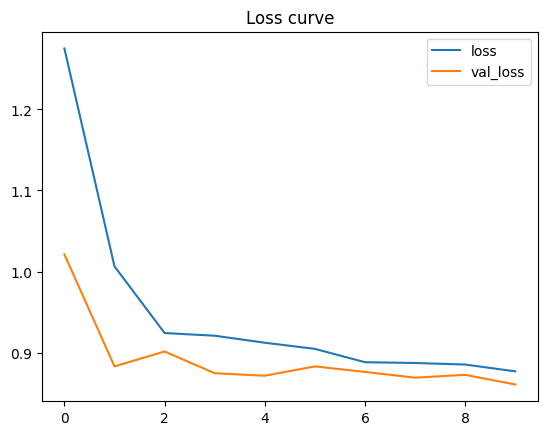

In [28]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title = 'Loss curve')

<Axes: title={'center': 'Accuracy curve'}>

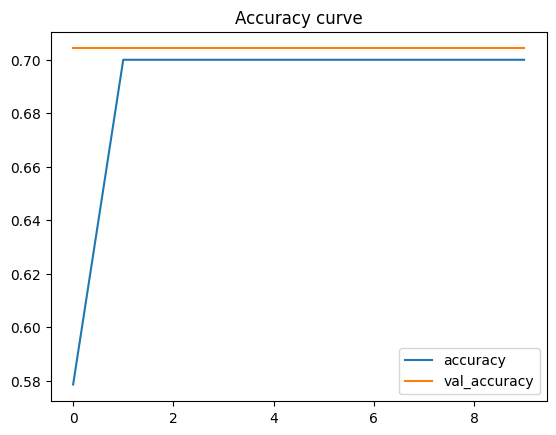

In [29]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title = 'Accuracy curve')

In [30]:
result = model.evaluate(X_test, y_test)

loss = result[0]
accuracy = result[1]
print(f"[+] Accuracy: {accuracy*100:.2f}%")

3/3 [==============================] - 2s 244ms/step - loss: 0.8608 - accuracy: 0.7042
[+] Accuracy: 70.42%


In [ ]:
# from keras.models import Model
# model.save('my_model_steel.keras')

In [ ]:
# from keras.models import load_model

# loaded_model = load_model('my_model.h5')


# Архитектура созданной нейронной сети

In [47]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 39, 39, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 10, 10, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 2, 2, 64)         

### Итоги.
Последний тест с использованием оригинальных изображений оказался провальным. Использование формата 1600*256 перегрузил дотсупную оперативную память.
Использования сжатых до формата 800*128 пиксилей привело к снижению эффективности нейросетей первого и второго типов, а для 13 слойной архитектуры привел к стагнации обучения уже на первой эпохе.

3/3 [==============================] - 10s 1s/step - loss: 1.2751 - accuracy: 0.5786 - val_loss: 1.0212 - val_accuracy: 0.7042
Epoch 2/10
3/3 [==============================] - 1s 195ms/step - loss: 1.0065 - accuracy: 0.7000 - val_loss: 0.8831 - val_accuracy: 0.7042
Epoch 3/10
3/3 [==============================] - 1s 214ms/step - loss: 0.9242 - accuracy: 0.7000 - val_loss: 0.9015 - val_accuracy: 0.7042
Epoch 4/10
3/3 [==============================] - 1s 215ms/step - loss: 0.9209 - accuracy: 0.7000 - val_loss: 0.8747 - val_accuracy: 0.7042
Epoch 5/10
3/3 [==============================] - 1s 216ms/step - loss: 0.9123 - accuracy: 0.7000 - val_loss: 0.8716 - val_accuracy: 0.7042

Притом функция ошибки продолжала уменьшаться ,но незначительно.

Лучшего результата удалось добиться используя архитектуру второго типа с пятью слоями и использованием расширенного агментацией датасета.

Так же стоит обратить внимание на огромное значение правильно составленного и размеченного датасета.
Так как в учебных целях мы использовали урезанный датасет, то конечные результаты недостаточны для применения подобных моделей в реальных проектах.
Не обладая нужными компетенциями сложно оценить наполненность и достаточность используемых для обучения данных.

Попытки добиться большей эффективности используя разные настройки параметров нейросети для сложных задач с ограниченным или ошибочно составленным датасетом - могут не иметь значимого эффекта.


